In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
artists_billboard = pd.read_csv("artists_billboard_fix3.csv")
artists_billboard.shape

(635, 11)

In [3]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [4]:
artists_billboard.groupby("top").size()

top
0    494
1    141
dtype: int64

/Users/ivan/anaconda3/envs/MIA/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


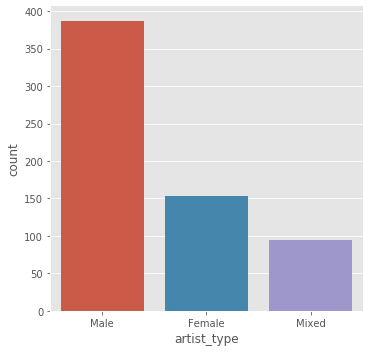

In [5]:
sb.factorplot('artist_type',data=artists_billboard, kind="count")

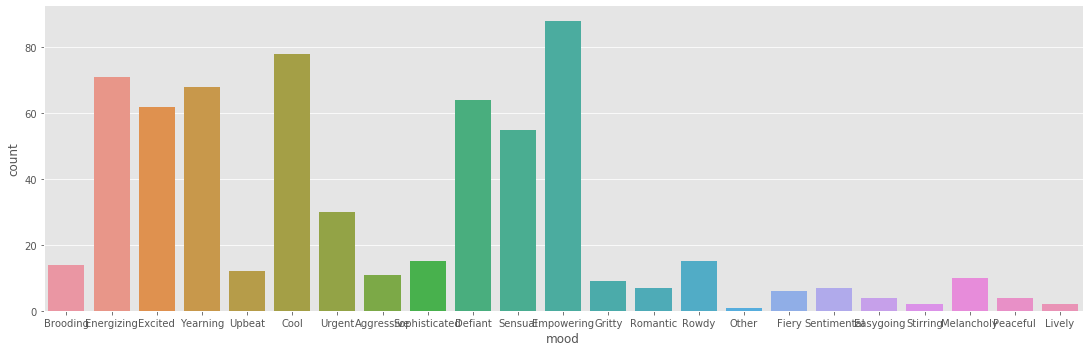

In [6]:
sb.factorplot("mood",data=artists_billboard,kind="count",aspect=3)

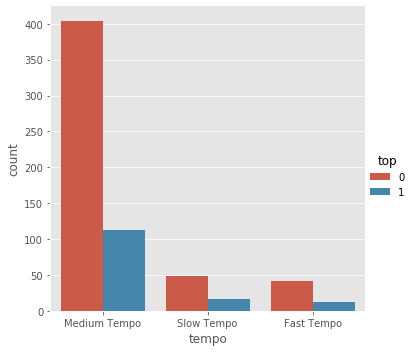

In [7]:
sb.factorplot("tempo",data=artists_billboard, hue='top',kind="count")
#hue hace el contraste o comparacion insitio de la categoria top[0y1]

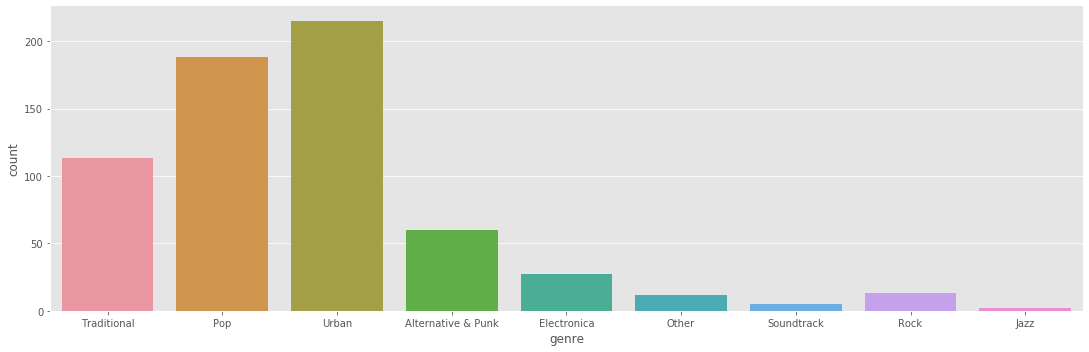

In [8]:
sb.factorplot("genre",data=artists_billboard,kind="count",aspect=3)

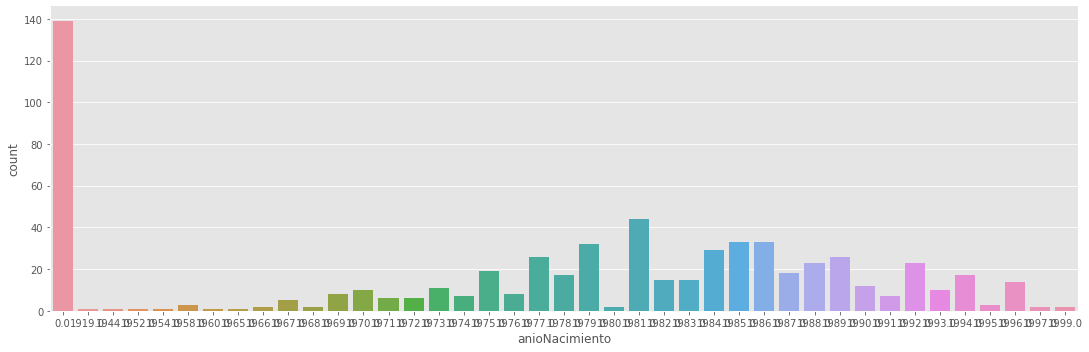

In [9]:
sb.factorplot('anioNacimiento',data=artists_billboard,kind="count",aspect=3)
#algo raro, en anio 0 hay 140 registros

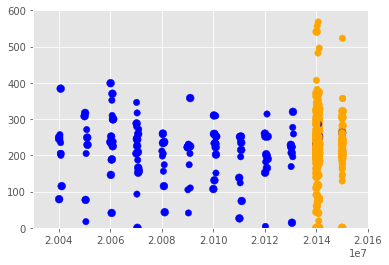

In [10]:
#equilibrar el arbol en una diferencia
f1=artists_billboard['chart_date'].values
f2=artists_billboard['durationSeg'].values

colores=['orange','blue']
tamanios=[60,40]
asignar=[]
asignar2=[]
for index , row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1,f2,c=asignar,s=tamanios)
plt.axis([20030101,20160101,0,600])
plt.show()

In [11]:
#arreglar los missing
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x:edad_fix(x['anioNacimiento']),axis=1)

def calcula_edad(anio,cuando):
    cad=str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio
artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']),axis=1)

In [12]:
#promediar edad
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


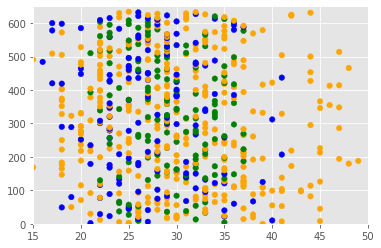

In [13]:

f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index
 
colores = ['orange','blue','green']
 
asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

In [14]:
#Mapeo de datos
#convertir datos en categoricos
#edades: menores de 21, de 21 a 26 etc
#duracion de canciones: entre 150 y 180 segundos
#tempo-> lento, medio o rapido a 0rapido, 1lento, 3 medio

#mood mapping
artists_billboard['moodEncoded']=artists_billboard['mood'].map({'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
#tempo mapping
artists_billboard['tempoEncoded']=artists_billboard['tempo'].map({'Fast Tempo':0,"Medium Tempo":2, "Slow Tempo":1,"":0}).astype(int)
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)
 
#Mapping edad. se hace con condicion , usando loc
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded']                         = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4
 
# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded']                          = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

Finalmente obtenemos un nuevo conjunto de datos llamado artists_encoded con el que tenemos los atributos definitivos para crear nuestro árbol. Para ello, quitamos todas las columnas que no necesitamos con «drop»:

In [15]:
drop_elements= ["id","title","artist","mood","tempo",'genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded =artists_billboard.drop(drop_elements, axis=1)

In [16]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

In [17]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

In [18]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [19]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

In [20]:
# librería de sklearn tree.DecisionTreeClasifier pues buscamos un árbol de clasificación (no de Regresión)
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['top'], axis=1), 
                               y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), 
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.564038
         4          0.647272
         5          0.603224
         6          0.626711
         7          0.640848


## Visualizacion de arbol

In [21]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values 

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )
        


In [22]:
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [ ]:
import pydot
(graph,) = pydot.graph_from_dot_file(r"tree1.dot)
graph.write_png(r"tree1.png")
img = Image.open(r»Datas\tree.png»)
img.show() 

In [ ]:
plt.imshow(img) #, cmap = ‘gray’, interpolation = ‘bicubic’)
plt.show()